
# <font color='darkblue'>Consumo de energia elétrica residencial individual</font>

### Dataset de estudo

Medições de consumo de energia elétrica em uma residência com taxa de amostragem de um minuto durante um período de quase 4 anos. Diferentes grandezas elétricas e alguns valores de submedição estão disponíveis.

fonte: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

### Objetivo

Análise exploratória dos dados e clusterização de perfis de consumo por meio de machine learning com algorítimos de aprendizagem não supervisionada

### Informações do conjunto de dados:

Este arquivo contém 2075259 medições reunidas em uma casa localizada em Sceaux (7km de Paris, França) entre dezembro de 2006 e novembro de 2010 (47 meses).

#### Notas:
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) representa a energia ativa consumida a cada minuto (em watt-hora) no domicílio por equipamentos elétricos não medidos nas submedições 1, 2 e 3.
2. O conjunto de dados contém alguns valores ausentes nas medições (cerca de 1,25% das linhas). Todos os carimbos de data/hora do calendário estão presentes no conjunto de dados, mas para alguns carimbos de data/hora, os valores de medição estão ausentes: um valor ausente é representado pela ausência de valor entre dois separadores de atributo ponto-e-vírgula consecutivos. Por exemplo, o conjunto de dados mostra valores ausentes em 28 de abril de 2007.

### Informações dos atributos:

1. date: Data no formato dd/mm/aaaa
2. time: hora no formato hh:mm:ss
3. global_active_power: potência ativa média global por minuto da família (em quilowatts)
4. global_reactive_power: potência reativa global média por minuto doméstica (em quilowatts)
5. voltage: tensão média por minuto (em volts)
6. global_intensity: intensidade de corrente média por minuto global doméstica (em amperes)
7. sub_metering_1: submedição de energia nº 1 (em watt-hora de energia ativa). Corresponde à cozinha, contendo principalmente máquina de lavar louça, forno e micro-ondas (os fogões não são elétricos, mas a gás).
8. sub_metering_2: submedição de energia nº 2 (em watt-hora de energia ativa). Corresponde à lavanderia, contendo máquina de lavar, secadora, geladeira e luz.
9. sub_metering_3: submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um aquecedor elétrico de água e um ar condicionado.

In [1]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Carregando os dados
dataset = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [3]:
# Visualizando o dataset
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Análise exploratória dos dados

In [4]:
# Verificando o tipo dos dados
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# Verificando a existência de valores ausentes no dataframe
cols = dataset.columns
for i in range(len(cols)):
    print('Coluna:', cols[i])
    print(dataset[cols[i]].isin(['?', np.nan]).value_counts())
    print()

Coluna: Date
False    2075259
Name: Date, dtype: int64

Coluna: Time
False    2075259
Name: Time, dtype: int64

Coluna: Global_active_power
False    2049280
True       25979
Name: Global_active_power, dtype: int64

Coluna: Global_reactive_power
False    2049280
True       25979
Name: Global_reactive_power, dtype: int64

Coluna: Voltage
False    2049280
True       25979
Name: Voltage, dtype: int64

Coluna: Global_intensity
False    2049280
True       25979
Name: Global_intensity, dtype: int64

Coluna: Sub_metering_1
False    2049280
True       25979
Name: Sub_metering_1, dtype: int64

Coluna: Sub_metering_2
False    2049280
True       25979
Name: Sub_metering_2, dtype: int64

Coluna: Sub_metering_3
False    2049280
True       25979
Name: Sub_metering_3, dtype: int64



In [6]:
# Transformando as colunas numéricas para o tipo float e identificando os valores missing como -1

def trans_float(str):
    try:
        num = float(str)
    except ValueError:
        num = -1
    return num

df = dataset.copy()
cols = dataset.iloc[:,2:8].columns
for i in cols:
    df[i] = df[i].apply(trans_float)

In [7]:
# Criando uma coluna com as informações de Data e Hora do tipo datetime
lista=[]

for i in range(len(df['Date'])):
    dt = datetime.strptime(df['Date'][i]+'-'+df['Time'][i], '%d/%m/%Y-%H:%M:%S')
    lista.append(dt)

df['Date-Time'] = lista

In [8]:
# Visualizando o resultado no dataframe
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date-Time
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [9]:
# Verificando o intervalo das medições
a = df['Date-Time'].min()
b = df['Date-Time'].max()
print(f'Início das medições:{a}')
print(f'Término das medições:{b}')

Início das medições:2006-12-16 17:24:00
Término das medições:2010-11-26 21:02:00


In [10]:
# Verificando os valores ausentes
df[df['Global_active_power'] == -1].sample(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date-Time
1713284,20/3/2010,12:08:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2010-03-20 12:08:00
1933541,20/8/2010,11:05:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2010-08-20 11:05:00
193666,30/4/2007,05:10:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2007-04-30 05:10:00
192418,29/4/2007,08:22:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2007-04-29 08:22:00
1713601,20/3/2010,17:25:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2010-03-20 17:25:00


In [11]:
# Verificando os dias mais impactados com valores missing
missing = df[df['Global_active_power'] == -1][['Date','Time']].groupby('Date').count().sort_values('Time', ascending=False).reset_index()        

(0.0, 1500.0)

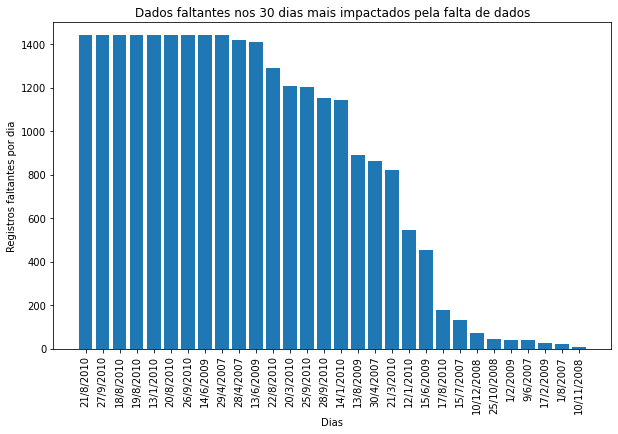

In [12]:
plt.figure(figsize=(10,6))
plt.bar('Date', 'Time', data=missing.head(30))
plt.ylabel("Registros faltantes por dia")
plt.xlabel("Dias")
plt.xticks(rotation=90) #.set(rotation=30, horizontalalignment='right')
plt.title('Dados faltantes nos 30 dias mais impactados pela falta de dados')
plt.ylim(0,1500)

In [13]:
# Removendo os valores ausentes
df_clear = df[df['Global_active_power'] != -1]

In [14]:
df_clear.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [15]:
# Reduzindo as informações para médias diárias para reduzir o tamanho do dataset
def convert_hour(txt):
    hora = datetime.strftime(txt,'%H')
    return hora

def convert_week(txt):
    hora = datetime.strftime(txt,'%V')
    return hora

def convert_wday(txt):
    hora = datetime.strftime(txt,'%w')
    return hora

df_clear['Hour-Time'] = df_clear['Date-Time'].apply(convert_hour)
df_clear['Week of Year'] = df_clear['Date-Time'].apply(convert_week)
df_clear['Week Day'] = df_clear['Date-Time'].apply(convert_wday)

In [16]:
df_summary = df_clear.groupby(['Week of Year', 'Week Day', 'Hour-Time'], 
                 as_index=False).mean()

### Para retormar carregue as bibliotecas e o arquivo já transformado a partir daqui

In [17]:
#df_summary.to_csv('summary.csv', index=False)
#df_summary = pd.read_csv('summary.csv')

In [18]:
df_summary.head()

,Week of Year,Week Day,Hour-Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,01,0,00,1.106742,0.076400,243.932750,4.523333,0.0,0.108333,11.745833
1,01,0,01,0.727592,0.075425,243.227292,3.025000,0.0,0.150000,6.545833
2,01,0,02,0.360033,0.113133,246.607000,1.595000,0.0,0.337500,0.170833
3,01,0,03,0.346633,0.095117,246.651958,1.501667,0.0,0.308333,0.170833
4,01,0,04,0.352883,0.103450,246.680333,1.548333,0.0,0.237500,0.175000


In [19]:
# Segmentando o dataset por dia da semana
wd = df_summary[['Week Day','Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']].groupby('Week Day').mean()
wd = wd.reset_index()
wd

,Week Day,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1.226806,1.814621,1.940950,5.950005
1,1,1.008388,0.836737,0.878390,6.292724
2,2,1.081055,0.786530,1.343094,6.444038
3,3,1.093318,1.090966,1.747680,6.413366
4,4,0.990907,0.796059,0.743288,6.143941
5,5,1.041954,0.877777,0.990563,6.696514
6,6,1.244235,1.710388,1.470686,7.455567


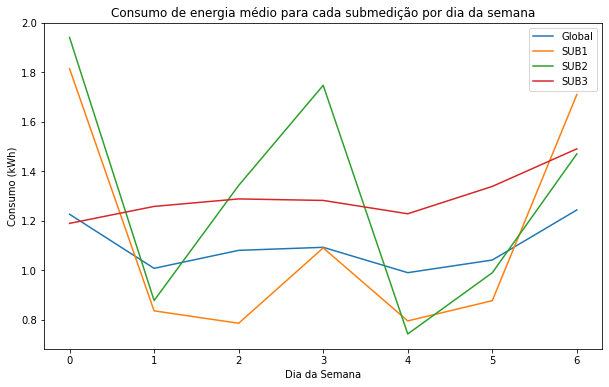

In [20]:
plt.figure(figsize=(10,6))
plt.plot(wd['Week Day'], wd['Global_active_power'], label= "Global")
plt.plot(wd['Week Day'], wd['Sub_metering_1'], label= "SUB1")
plt.plot(wd['Week Day'], wd['Sub_metering_2'], label= "SUB2")
plt.plot(wd['Week Day'], wd['Sub_metering_3']/5, label= "SUB3")
plt.title('Consumo de energia médio para cada submedição por dia da semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.show()

In [21]:
hd = df_summary[['Hour-Time','Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']].groupby('Hour-Time').mean()
hd = hd.reset_index()
hd.head(3)

,Hour-Time,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,00,0.658342,0.357847,0.546037,2.967644
1,01,0.537582,0.241566,0.393336,2.344373
2,02,0.479322,0.143932,0.344590,2.021663


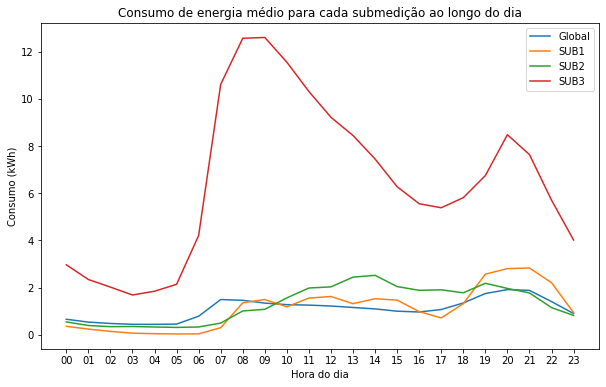

In [22]:
plt.figure(figsize=(10,6))
plt.plot(hd['Hour-Time'], hd['Global_active_power'], label= "Global")
plt.plot(hd['Hour-Time'], hd['Sub_metering_1'], label= "SUB1")
plt.plot(hd['Hour-Time'], hd['Sub_metering_2'], label= "SUB2")
plt.plot(hd['Hour-Time'], hd['Sub_metering_3'], label= "SUB3")
plt.title('Consumo de energia médio para cada submedição ao longo do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.show()

In [23]:
wy = df_summary[['Week of Year','Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']].groupby('Week of Year').mean()
wy = wy.reset_index()
wy.head()

,Week of Year,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,01,1.356829,0.989112,1.585317,6.775918
1,02,1.433419,1.537134,1.373697,7.597496
2,03,1.554622,1.759535,1.602635,8.634231
3,04,1.474168,1.310565,1.529201,8.223069
4,05,1.548847,1.343974,1.586224,9.028020


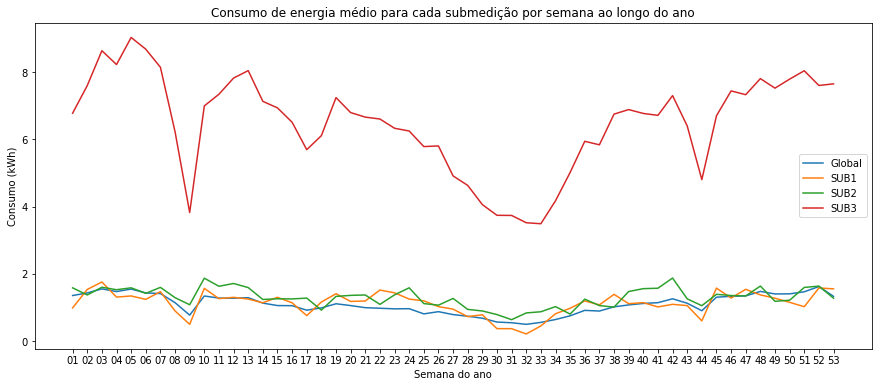

In [24]:
plt.figure(figsize=(15,6))
plt.plot(wy['Week of Year'], wy['Global_active_power'], label= "Global")
plt.plot(wy['Week of Year'], wy['Sub_metering_1'], label= "SUB1")
plt.plot(wy['Week of Year'], wy['Sub_metering_2'], label= "SUB2")
plt.plot(wy['Week of Year'], wy['Sub_metering_3'], label= "SUB3")
plt.title('Consumo de energia médio para cada submedição por semana ao longo do ano')
plt.xlabel('Semana do ano')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.show()

### Aplicação de Machine Learning

In [25]:
# Tamanho do dataframe sintetizado
df_summary.shape

(8904, 10)

In [26]:
# Selecionando as colunas a serem utilizadas para a Clusterização dos dados
colunas = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df_summary[colunas].head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1.106742,0.0,0.108333,11.745833
1,0.727592,0.0,0.150000,6.545833
2,0.360033,0.0,0.337500,0.170833
3,0.346633,0.0,0.308333,0.170833
4,0.352883,0.0,0.237500,0.175000


#### Determinação do fator K

In [27]:
# Aplicando a redução de dimensionalidade
pca = PCA(n_components=2).fit_transform(df_summary[colunas])

In [28]:
# Definindo um range para k
k_range = range(1,16)

In [29]:
# Aplicando o modelo K-Means para dada valor de K
k_means_var = [KMeans(n_clusters= k).fit(pca) for k in k_range]

In [30]:
# Ajustando o centroide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [31]:
# Calculando a distância euclidiana de cada ponto para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis= 1) for ke in k_euclid]

In [32]:
# soma do quadrado das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [33]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [34]:
# Soma do quadrado entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

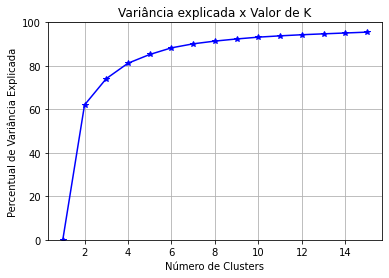

In [70]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim(0,100)
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância explicada x Valor de K')
plt.show()

In [36]:
# Criando um modelo com k = 6
modelo_v1 = KMeans(n_clusters= 6)
modelo_v1.fit(pca)

KMeans(n_clusters=6)

In [37]:
# Obtendo os valorses mínimos e máximos e organizando o shape
x_min, x_max = pca[:,0].min(), pca[:,0].max()
y_min, y_max = pca[:,1].min(), pca[:,1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

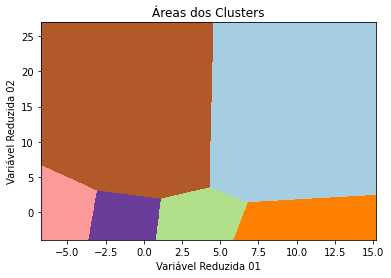

In [38]:
# Plot das áreas dos clusters
plt.figure()
plt.clf()
plt.imshow(Z, 
           interpolation= 'nearest', 
           extent= (xx.min(), xx.max(), yy.min(), yy.max()), 
           cmap= plt.cm.Paired, 
           aspect = 'auto', 
           origin= 'lower')
plt.xlabel('Variável Reduzida 01')
plt.ylabel('Variável Reduzida 02')
plt.title('Áreas dos Clusters')
plt.show()

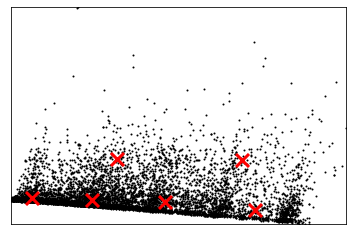

In [39]:
# Plot dos centróides

plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize= 2)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:,0], centroids[:,1], marker= 'x', s= 169, linewidths= 3, color= 'r', zorder= 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [40]:
# silhouette_score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric= 'euclidean')

0.49017874961393576

Foram repetidas as últimas cinco etapas para outras quantidades de clusters 'K' e obtidos os seguintes resultados para 'silhouette_score', utilizando todas as colunas do dataframe 'df_summary':
1. K = 4 => silhouette_score = 0.38647360877044973
2. K = 6 => silhouette_score = 0.4136982960864877
3. K = 7 => silhouette_score = 0.4220827066057466
4. K = 8 => silhouette_score = 0.41182937813651055
5. K = 10 => silhouette_score = 0.3842245126010502

Na tentativa de aumentar o score, foi realizada mais uma rodada levando em consideração apenas as quatro colunas de medição de consumo de energia

1. K = 5 => silhouette_score = 0.46825291117086826
2. K = 6 => silhouette_score = 0.49017874961393576
3. K = 7 => silhouette_score = 0.4819682957508566
4. K = 8 => silhouette_score = 0.49270862590642656
5. K = 10 => silhouette_score = 0.46371102871898534

Foi adotada a solução do dataframe mais reduzido com 6 clusters, tendo em vista trabalhar com um número de cluters mais baixo, muito próximo da máxima performance possível.

#### Criando o cluster map com os cluster do modelo que apresentou o melhor score.

In [41]:
df_summary['Cluster'] = modelo_v1.labels_

In [42]:
df_summary.head()

,Week of Year,Week Day,Hour-Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Cluster
0,01,0,00,1.106742,0.076400,243.932750,4.523333,0.0,0.108333,11.745833,1
1,01,0,01,0.727592,0.075425,243.227292,3.025000,0.0,0.150000,6.545833,4
2,01,0,02,0.360033,0.113133,246.607000,1.595000,0.0,0.337500,0.170833,2
3,01,0,03,0.346633,0.095117,246.651958,1.501667,0.0,0.308333,0.170833,2
4,01,0,04,0.352883,0.103450,246.680333,1.548333,0.0,0.237500,0.175000,2


In [43]:
# Calculando os consumos médios por cluster
cluster_means = df_summary[['Cluster']+colunas].groupby('Cluster').mean().reset_index()
cluster_means['Cluster'] = ['Cluster '+ str(i) for i in cluster_means['Cluster']]
#cluster_means = cluster_means.set_index('Cluster')
cluster_means

,Cluster,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,Cluster 0,2.387411,4.637971,6.863943,13.801694
1,Cluster 1,1.435537,1.484707,0.836456,9.870850
2,Cluster 2,0.514783,0.253402,0.496950,1.339822
3,Cluster 3,1.769778,1.571823,0.765704,15.913314
4,Cluster 4,0.933601,0.775966,0.617560,5.184888
5,Cluster 5,1.660449,2.775161,6.347977,5.839891


### Análise dos Clusters

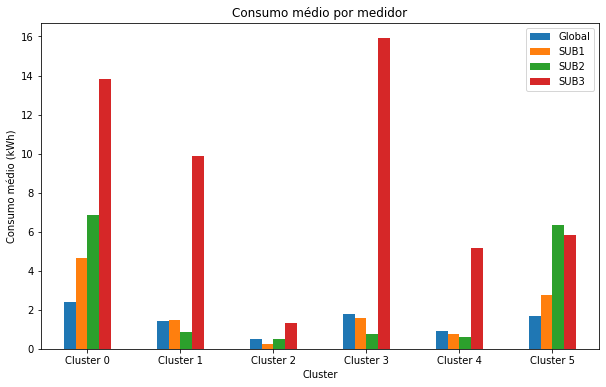

In [44]:
# Consumo médio por Cluster

colunas = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
legenda = ['Global', 'SUB1', 'SUB2', 'SUB3']

cluster_means.plot(x='Cluster', y=colunas, kind="bar",figsize=(10,6), label= legenda)
plt.ylabel('Consumo médio (kWh)')
plt.title('Consumo médio por medidor')
plt.xticks(rotation=0)
plt.show()

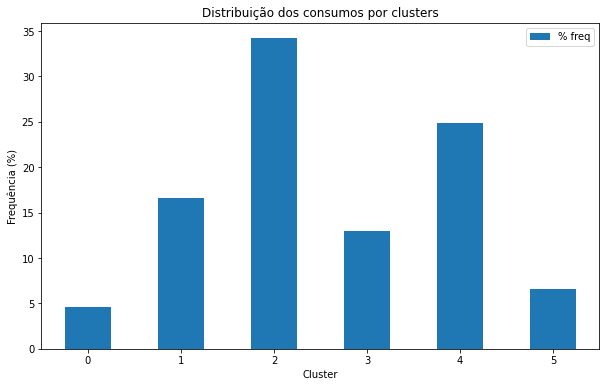

In [45]:
# Análise da distribuição dos consumos por clusters

freq = df_summary['Cluster'].value_counts().reset_index()
freq.columns = ['Cluster', 'freq']
freq['% freq'] = round(100 * freq['freq'] / freq['freq'].sum(), 2)
freq = freq.sort_values('Cluster')
freq 

freq.plot(x='Cluster', y= '% freq', kind="bar",figsize=(10,6))
plt.xlabel('Cluster')
plt.ylabel('Frequência (%)')
plt.title('Distribuição dos consumos por clusters')
plt.xticks(rotation=0)
plt.show()

In [46]:
df_summary.head(3)

,Week of Year,Week Day,Hour-Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Cluster
0,01,0,00,1.106742,0.076400,243.932750,4.523333,0.0,0.108333,11.745833,1
1,01,0,01,0.727592,0.075425,243.227292,3.025000,0.0,0.150000,6.545833,4
2,01,0,02,0.360033,0.113133,246.607000,1.595000,0.0,0.337500,0.170833,2


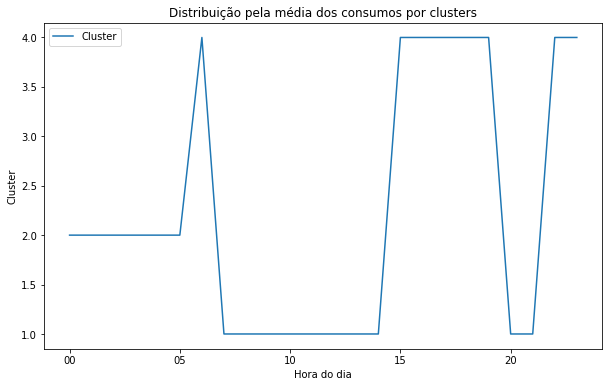

In [47]:
# Distribuição de consumo a partir da média anual horária

# Aplicando a redução de dimensionalidade
pca_hd = PCA(n_components=2).fit_transform(hd[colunas])

hd['Cluster'] = modelo_v1.predict(pca_hd)

hd.plot(x='Hour-Time', y= 'Cluster', kind="line",figsize=(10,6))
plt.xlabel('Hora do dia')
plt.ylabel('Cluster')
plt.title('Distribuição pela média dos consumos por clusters')
plt.xticks(rotation=0)
plt.show()

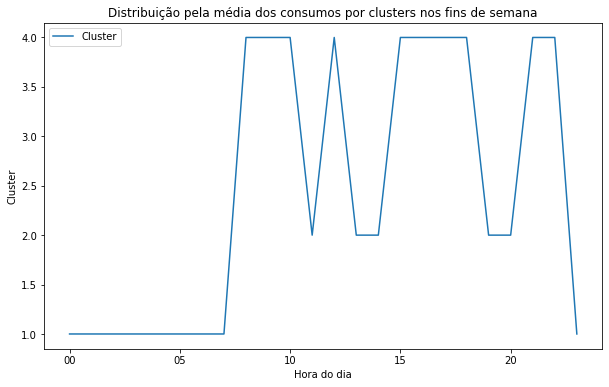

In [48]:
# Distribuição de consumo a partir da média anual horária dos fins de semana

hd_weekend = df_summary[df_summary['Week Day'].isin(['0','6'])][['Hour-Time']+colunas].groupby('Hour-Time').mean()
hd_weekend = hd_weekend.reset_index()

# Aplicando a redução de dimensionalidade
pca_hd_weekend = PCA(n_components=2).fit_transform(hd_weekend[colunas])

hd_weekend['Cluster'] = modelo_v1.predict(pca_hd_weekend)

hd_weekend.plot(x='Hour-Time', y= 'Cluster', kind="line",figsize=(10,6))
plt.xlabel('Hora do dia')
plt.ylabel('Cluster')
plt.title('Distribuição pela média dos consumos por clusters nos fins de semana')
plt.xticks(rotation=0)
plt.show()

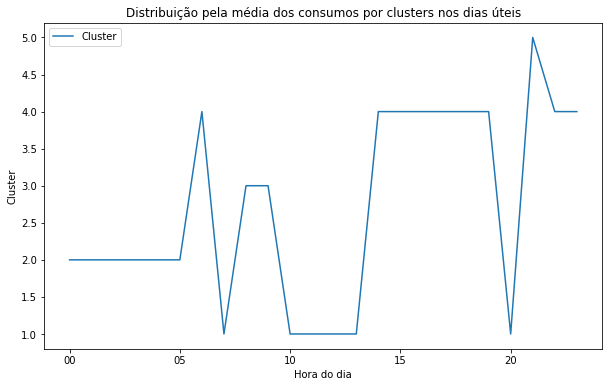

In [49]:
# Distribuição de consumo a partir da média anual horária durante os dias úteis

hd_week = df_summary[df_summary['Week Day'].isin(['1','2','3','4','5'])][['Hour-Time']+colunas].groupby('Hour-Time').mean()
hd_week = hd_week.reset_index()

# Aplicando a redução de dimensionalidade
pca_hd_week = PCA(n_components=2).fit_transform(hd_week[colunas])

hd_week['Cluster'] = modelo_v1.predict(pca_hd_week)

hd_week.plot(x='Hour-Time', y= 'Cluster', kind="line",figsize=(10,6))
plt.xlabel('Hora do dia')
plt.ylabel('Cluster')
plt.title('Distribuição pela média dos consumos por clusters nos dias úteis')
plt.xticks(rotation=0)
plt.show()

Análise dos horários de pico de consumo ao longo do ano, percebendo que pela análise exploratória que aparentemente temos dois movimentos interessantes no consumo nos períodos das 07h ás 12h e das 19h as 22h. A ideia de fugir do consumo médío é não mascarar as possíveis variações diluídas no consumo médio diário.

In [50]:
# Distribuição de consumo a partir da média anual horária durante os dias úteis

wy = df_summary[['Week of Year'] + colunas].groupby('Week of Year').mean()
wy = wy.reset_index()
wy.head()

,Week of Year,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,01,1.356829,0.989112,1.585317,6.775918
1,02,1.433419,1.537134,1.373697,7.597496
2,03,1.554622,1.759535,1.602635,8.634231
3,04,1.474168,1.310565,1.529201,8.223069
4,05,1.548847,1.343974,1.586224,9.028020


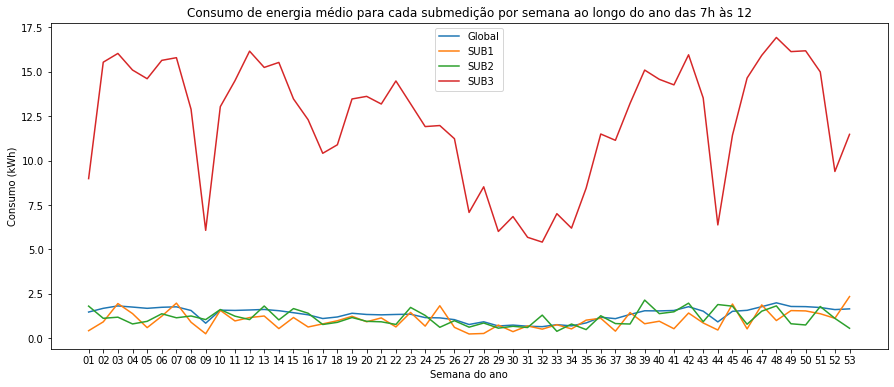

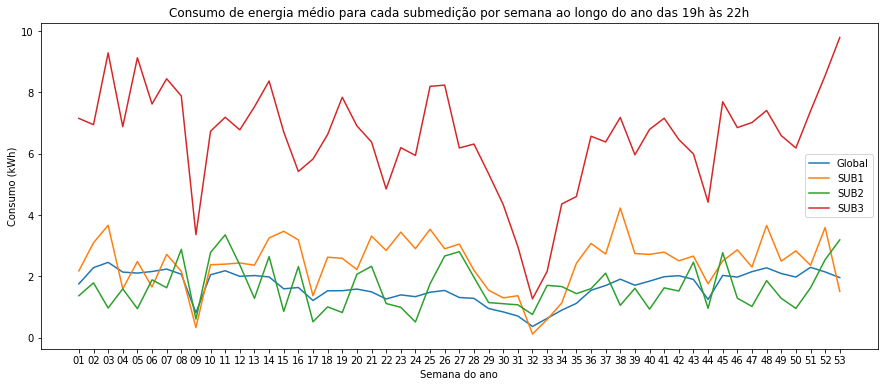

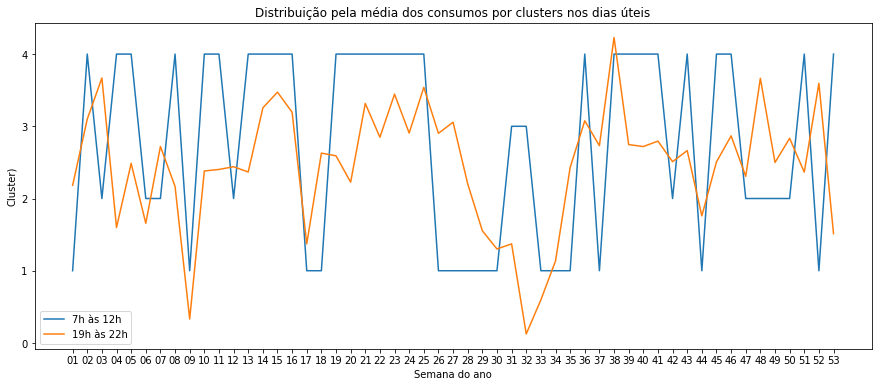

In [91]:
# Aplicando os filtros para os dois horários de pico
# Dias Úteis das 7h as 12h
wy_7_12 = df_summary[(df_summary['Week Day'].isin(['1','2','3','4','5'])) & 
                     (df_summary['Hour-Time'].isin(['07','08','09','10','11','12']))]

wy_7_12 = wy_7_12[['Week of Year']+colunas].groupby('Week of Year').mean().reset_index()

# Dias Úteis das 19h as 22h
wy_19_22 = df_summary[(df_summary['Week Day'].isin(['1','2','3','4','5'])) & 
                     (df_summary['Hour-Time'].isin(['19','20','21','22']))]

wy_19_22 = wy_19_22[['Week of Year']+colunas].groupby('Week of Year').mean().reset_index()


# Aplicando a redução de dimensionalidade
pca_wy_7_12 = PCA(n_components=2).fit_transform(wy_7_12[colunas])
pca_wy_19_22 = PCA(n_components=2).fit_transform(wy_19_22[colunas])

wy_7_12['Cluster'] = modelo_v1.predict(pca_wy_7_12)
wy_19_22['Cluster'] = modelo_v1.predict(pca_wy_19_22)


plt.figure(figsize=(15,6))
plt.plot(wy_7_12['Week of Year'], wy_7_12['Global_active_power'], label= "Global")
plt.plot(wy_7_12['Week of Year'], wy_7_12['Sub_metering_1'], label= "SUB1")
plt.plot(wy_7_12['Week of Year'], wy_7_12['Sub_metering_2'], label= "SUB2")
plt.plot(wy_7_12['Week of Year'], wy_7_12['Sub_metering_3'], label= "SUB3")
plt.title('Consumo de energia médio para cada submedição por semana ao longo do ano das 7h às 12')
plt.xlabel('Semana do ano')
plt.ylabel('Consumo (kWh)')
plt.legend()

plt.figure(figsize=(15,6))
plt.plot(wy_19_22['Week of Year'], wy_19_22['Global_active_power'], label= "Global")
plt.plot(wy_19_22['Week of Year'], wy_19_22['Sub_metering_1'], label= "SUB1")
plt.plot(wy_19_22['Week of Year'], wy_19_22['Sub_metering_2'], label= "SUB2")
plt.plot(wy_19_22['Week of Year'], wy_19_22['Sub_metering_3'], label= "SUB3")
plt.title('Consumo de energia médio para cada submedição por semana ao longo do ano das 19h às 22h')
plt.xlabel('Semana do ano')
plt.ylabel('Consumo (kWh)')
plt.legend()

plt.figure(figsize=(15,6))
plt.plot(wy_7_12['Week of Year'], wy_7_12['Cluster'], label= "7h às 12h")
plt.plot(wy_19_22['Week of Year'], wy_19_22['Sub_metering_1'], label= "19h às 22h")
plt.title('Distribuição pela média dos consumos por clusters nos dias úteis')
plt.xlabel('Semana do ano')
plt.ylabel('Cluster)')
plt.legend()
plt.show()